Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import tensorflow as tf
from __future__ import print_function
import tensorflow.keras as keras 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Concatenate,BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Input,AveragePooling2D
from tensorflow.keras.models import Model 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from tensorflow.keras.callbacks import EarlyStopping 

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
early_stopping=EarlyStopping(monitor='val_accuracy',patience = 1)

Проверим работу GPU

In [3]:

def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print("GPU работает:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

 CPU работает:
100 циклов: 364.33ms
GPU работает:
100 циклов: 346.18ms
 CPU работает:
100 циклов: 340.33ms
GPU работает:
100 циклов: 9.01ms


Загрузим датасет

In [4]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')
print(np.unique(y_train), 'Классы')
# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
[0 1 2 3 4 5 6 7 8 9] Классы


Визуализация датасета

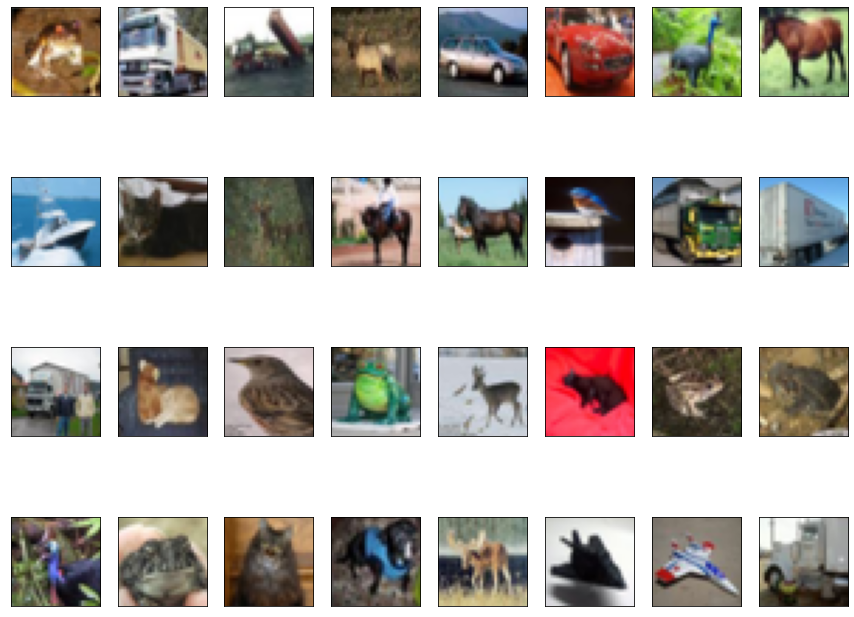

In [5]:
some_samples = x_train[:32]

fig = plt.figure(figsize=(15, 12))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
num_classes = len(classes)

In [6]:
# OHE
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
y_train.shape

(50000, 10)

In [8]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

Функция для тестирования моделей

In [9]:
def testing(model,num_iter):
    start = time.time()
    res=[]
    res_tr=[]
    for _ in range(num_iter):
        model.set_weights(ww)
        hh = model.fit(x=x_train,y=y_train, epochs=epochs,\
                       batch_size=batch_size, validation_data=(x_test, y_test), verbose=1,workers = 10,\
                       callbacks=[early_stopping])
        res.append(hh.history['val_accuracy'][-1])
        res_tr.append(hh.history['accuracy'][-1])
    res = np.array(res)
    
    d={'epochs':epochs,
        'res_max' : res.max(),
        'res_min' : res.min(),
        'res_mean' : res.mean(),
        'res_std' : res.std(),
       'batch_size':batch_size,
       'res_train_mean':np.array(res_tr).mean(),
       'time_iter': (time.time() - start)/num_iter
    }    
    
    return d

In [10]:
# Хранилище результатов
history = pd.DataFrame()

## Тестирование моделей

In [11]:
# Гиперпараметры модели
epochs = 5
batch_size = 256
inpit_shape = x_test.shape[1:]
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [13]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=512,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)
x2 = Dropout(0.2)(x2)

x3 = Conv2D(filters=128,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.2)(x3)


x4 = Flatten()(x3)
x4 = Dense(256,activation='sigmoid')(x4)
x4 = Dense(128,activation='relu')(x4)
out = Dense(10,activation='softmax')(x4)

model_1 = Model(inputs = input_1,outputs = out,name = 'model_1' )
model_1.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_1.get_weights()
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 512)       38912     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       2097408   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 256)         0   

In [14]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_1.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_1,2)
res['model'] = 'model_1'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
196/196 [==============================] - 46s 211ms/step - loss: 2.0615 - accuracy: 0.2444 - val_loss: 1.7416 - val_accuracy: 0.3824
Epoch 2/20
196/196 [==============================] - 39s 200ms/step - loss: 1.6604 - accuracy: 0.4006 - val_loss: 1.5305 - val_accuracy: 0.4564
Epoch 3/20
196/196 [==============================] - 39s 200ms/step - loss: 1.5089 - accuracy: 0.4549 - val_loss: 1.4310 - val_accuracy: 0.4846
Epoch 4/20
196/196 [==============================] - 39s 201ms/step - loss: 1.4060 - accuracy: 0.4917 - val_loss: 1.3277 - val_accuracy: 0.5220
Epoch 5/20
196/196 [==============================] - 39s 201ms/step - loss: 1.3270 - accuracy: 0.5229 - val_loss: 1.3109 - val_accuracy: 0.5319
Epoch 6/20
196/196 [==============================] - 39s 201ms/step - loss: 1.2613 - accuracy: 0.5501 - val_loss: 1.2220 - val_accuracy: 0.5682
Epoch 7/20
196/196 [==============================] - 40s 202ms/step - loss: 1.2085 - accuracy: 0.5708 - val_loss: 1.1584 - val_ac

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.6674,0.0128,256.0,0.66982,676.529251,model_1,0.0001


In [15]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=512,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)
x2 = Dropout(0.2)(x2)

x3 = Conv2D(filters=128,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.2)(x3)


x4 = Flatten()(x3)
x4 = Dense(256,activation='relu')(x4)
x4 = Dense(128,activation='relu')(x4)
out = Dense(10,activation='softmax')(x4)

model_2 = Model(inputs = input_1,outputs = out,name = 'model_2' )
model_2.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_2.get_weights()
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 512)       38912     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 512)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2097408   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 256)         0   

In [16]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_2.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_2,2)
res['model'] = 'model_2'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
196/196 [==============================] - 51s 260ms/step - loss: 1.8985 - accuracy: 0.3011 - val_loss: 1.6187 - val_accuracy: 0.4176
Epoch 2/20
196/196 [==============================] - 51s 259ms/step - loss: 1.5341 - accuracy: 0.4407 - val_loss: 1.4085 - val_accuracy: 0.4878
Epoch 3/20
196/196 [==============================] - 51s 259ms/step - loss: 1.3929 - accuracy: 0.4966 - val_loss: 1.3344 - val_accuracy: 0.5185
Epoch 4/20
196/196 [==============================] - 51s 259ms/step - loss: 1.2966 - accuracy: 0.5338 - val_loss: 1.2234 - val_accuracy: 0.5672
Epoch 5/20
196/196 [==============================] - 51s 259ms/step - loss: 1.2111 - accuracy: 0.5683 - val_loss: 1.1406 - val_accuracy: 0.5964
Epoch 6/20
196/196 [==============================] - 51s 259ms/step - loss: 1.1460 - accuracy: 0.5950 - val_loss: 1.0818 - val_accuracy: 0.6165
Epoch 7/20
196/196 [==============================] - 51s 259ms/step - loss: 1.0779 - accuracy: 0.6203 - val_loss: 1.0245 - val_ac

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001


In [17]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=512,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16



x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)


x3 = Conv2D(filters=128,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)



x4 = Flatten()(x3)
x4 = Dense(256,activation='relu')(x4)
x4 = Dense(128,activation='relu')(x4)
out = Dense(10,activation='softmax')(x4)

model_3 = Model(inputs = input_1,outputs = out,name = 'model_3' )
model_3.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_3.get_weights()
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 512)       38912     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       2097408   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         295040    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 128)         0   

In [18]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_3.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_3,2)
res['model'] = 'model_3'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
196/196 [==============================] - 39s 195ms/step - loss: 1.8405 - accuracy: 0.3346 - val_loss: 1.5619 - val_accuracy: 0.4452
Epoch 2/20
196/196 [==============================] - 38s 194ms/step - loss: 1.4719 - accuracy: 0.4716 - val_loss: 1.3946 - val_accuracy: 0.5027
Epoch 3/20
196/196 [==============================] - 38s 194ms/step - loss: 1.3369 - accuracy: 0.5238 - val_loss: 1.3096 - val_accuracy: 0.5306
Epoch 4/20
196/196 [==============================] - 38s 195ms/step - loss: 1.2290 - accuracy: 0.5651 - val_loss: 1.2081 - val_accuracy: 0.5773
Epoch 5/20
196/196 [==============================] - 38s 194ms/step - loss: 1.1509 - accuracy: 0.5978 - val_loss: 1.1791 - val_accuracy: 0.5793
Epoch 6/20
196/196 [==============================] - 38s 193ms/step - loss: 1.0816 - accuracy: 0.6230 - val_loss: 1.0832 - val_accuracy: 0.6226
Epoch 7/20
196/196 [==============================] - 38s 194ms/step - loss: 1.0238 - accuracy: 0.6448 - val_loss: 1.0745 - val_ac

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001


In [19]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=512,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16



x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)


x3 = Conv2D(filters=128,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)



x4 = Flatten()(x3)
x4 = Dense(256,activation='relu')(x4)
out = Dense(10,activation='softmax')(x4)

model_4 = Model(inputs = input_1,outputs = out,name = 'model_4' )
model_4.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_4.get_weights()
model_4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 512)       38912     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       2097408   
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         295040    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 128)         0   

In [20]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_4.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_4,2)
res['model'] = 'model_4'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
196/196 [==============================] - 39s 195ms/step - loss: 1.8073 - accuracy: 0.3494 - val_loss: 1.5368 - val_accuracy: 0.4454
Epoch 2/20
196/196 [==============================] - 38s 194ms/step - loss: 1.4386 - accuracy: 0.4860 - val_loss: 1.3892 - val_accuracy: 0.5093
Epoch 3/20
196/196 [==============================] - 38s 194ms/step - loss: 1.2975 - accuracy: 0.5425 - val_loss: 1.2591 - val_accuracy: 0.5579
Epoch 4/20
196/196 [==============================] - 38s 193ms/step - loss: 1.1935 - accuracy: 0.5800 - val_loss: 1.1807 - val_accuracy: 0.5904
Epoch 5/20
196/196 [==============================] - 38s 195ms/step - loss: 1.1192 - accuracy: 0.6107 - val_loss: 1.1330 - val_accuracy: 0.6043
Epoch 6/20
196/196 [==============================] - 38s 194ms/step - loss: 1.0564 - accuracy: 0.6320 - val_loss: 1.0698 - val_accuracy: 0.6255
Epoch 7/20
196/196 [==============================] - 38s 193ms/step - loss: 1.0035 - accuracy: 0.6519 - val_loss: 1.0332 - val_ac

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001


In [21]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16



x2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)


x3 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)



x4 = Flatten()(x3)
x4 = Dense(256,activation='relu')(x4)
x4 = Dense(128,activation='relu')(x4)
out = Dense(10,activation='softmax')(x4)

model_5 = Model(inputs = input_1,outputs = out,name = 'model_5' )
model_5.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_5.get_weights()
model_5.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 1024)      77824     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 512)       8389120   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 256)         1179904   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 256)         0   

In [22]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 128
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_5.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_5,2)
res['model'] = 'model_5'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
391/391 [==============================] - 223s 553ms/step - loss: 1.6966 - accuracy: 0.3824 - val_loss: 1.4345 - val_accuracy: 0.4862
Epoch 2/20
391/391 [==============================] - 211s 541ms/step - loss: 1.3023 - accuracy: 0.5372 - val_loss: 1.1782 - val_accuracy: 0.5833
Epoch 3/20
391/391 [==============================] - 211s 541ms/step - loss: 1.1020 - accuracy: 0.6120 - val_loss: 1.0389 - val_accuracy: 0.6357
Epoch 4/20
391/391 [==============================] - 211s 540ms/step - loss: 0.9703 - accuracy: 0.6614 - val_loss: 0.9630 - val_accuracy: 0.6648
Epoch 5/20
391/391 [==============================] - 209s 534ms/step - loss: 0.8701 - accuracy: 0.6980 - val_loss: 0.9067 - val_accuracy: 0.6814
Epoch 6/20
391/391 [==============================] - 209s 534ms/step - loss: 0.7894 - accuracy: 0.7282 - val_loss: 0.8648 - val_accuracy: 0.7034
Epoch 7/20
391/391 [==============================] - 209s 535ms/step - loss: 0.7197 - accuracy: 0.7521 - val_loss: 0.8450 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001


In [23]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 5,strides =1,padding = 'same')(input_1)
x1 = BatchNormalization()(x1)
x1 = LeakyReLU()(x1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16



x2 = Conv2D(filters=512,kernel_size = 4,strides =1,padding = 'same')(x1)
x2 = BatchNormalization()(x2)
x2 = LeakyReLU()(x2)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)


x3 = Conv2D(filters=256,kernel_size = 3,strides =1,padding = 'same')(x2)
x3 = BatchNormalization()(x3)
x3 = LeakyReLU()(x3)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)



x4 = Flatten()(x3)
x4 = Dense(256,activation='relu')(x4)
x4 = Dense(128,activation='relu')(x4)
out = Dense(10,activation='softmax')(x4)

model_6 = Model(inputs = input_1,outputs = out,name = 'model_6' )
model_6.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_6.get_weights()
model_6.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 1024)      77824     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 1024)      4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 1024)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 512)       8389120   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 512)       2048

In [24]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 128
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_6.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_6,2)
res['model'] = 'model_6'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
391/391 [==============================] - 237s 603ms/step - loss: 1.3077 - accuracy: 0.5300 - val_loss: 2.8367 - val_accuracy: 0.1365
Epoch 2/20
391/391 [==============================] - 235s 601ms/step - loss: 0.9170 - accuracy: 0.6781 - val_loss: 1.0946 - val_accuracy: 0.6217
Epoch 3/20
391/391 [==============================] - 234s 598ms/step - loss: 0.7584 - accuracy: 0.7373 - val_loss: 1.0564 - val_accuracy: 0.6427
Epoch 4/20
391/391 [==============================] - 234s 600ms/step - loss: 0.6416 - accuracy: 0.7778 - val_loss: 1.1636 - val_accuracy: 0.6113
Epoch 1/20
391/391 [==============================] - 235s 602ms/step - loss: 1.3240 - accuracy: 0.5261 - val_loss: 2.9768 - val_accuracy: 0.2628
Epoch 2/20
391/391 [==============================] - 235s 601ms/step - loss: 0.9369 - accuracy: 0.6714 - val_loss: 1.3901 - val_accuracy: 0.5312
Epoch 3/20
391/391 [==============================] - 235s 602ms/step - loss: 0.7658 - accuracy: 0.7316 - val_loss: 1.0162 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001


In [25]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 5,strides =1,padding = 'same')(input_1)
x1 = BatchNormalization()(x1)
x1 = LeakyReLU()(x1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16



x2 = Conv2D(filters=512,kernel_size = 4,strides =1,padding = 'same')(x1)
x2 = BatchNormalization()(x2)
x2 = LeakyReLU()(x2)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)


x3 = Conv2D(filters=256,kernel_size = 3,strides =1,padding = 'same')(x2)
x3 = BatchNormalization()(x3)
x3 = LeakyReLU()(x3)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)

x5 = Conv2D(filters=512,kernel_size = 4,strides =1,padding = 'valid')(x3)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU()(x5)



x4 = Flatten()(x5)
x4 = Dense(512,activation='relu')(x4)
x4 = Dense(256,activation='relu')(x4)
out = Dense(10,activation='softmax')(x4)

model_7 = Model(inputs = input_1,outputs = out,name = 'model_7' )
model_7.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_7.get_weights()
model_7.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 1024)      77824     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 1024)      4096      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 1024)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 512)       8389120   
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 512)       2048

In [26]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 128
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_7.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_7,2)
res['model'] = 'model_7'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
391/391 [==============================] - 237s 604ms/step - loss: 1.2081 - accuracy: 0.5708 - val_loss: 3.0638 - val_accuracy: 0.1830
Epoch 2/20
391/391 [==============================] - 235s 602ms/step - loss: 0.8091 - accuracy: 0.7164 - val_loss: 0.9400 - val_accuracy: 0.6746
Epoch 3/20
391/391 [==============================] - 236s 604ms/step - loss: 0.6219 - accuracy: 0.7857 - val_loss: 0.9368 - val_accuracy: 0.6721
Epoch 1/20
391/391 [==============================] - 236s 604ms/step - loss: 1.2405 - accuracy: 0.5560 - val_loss: 3.1908 - val_accuracy: 0.1553
Epoch 2/20
391/391 [==============================] - 235s 601ms/step - loss: 0.8177 - accuracy: 0.7123 - val_loss: 0.9506 - val_accuracy: 0.6663
Epoch 3/20
391/391 [==============================] - 236s 603ms/step - loss: 0.6346 - accuracy: 0.7802 - val_loss: 0.9252 - val_accuracy: 0.6796
Epoch 4/20
391/391 [==============================] - 240s 613ms/step - loss: 0.4941 - accuracy: 0.8310 - val_loss: 0.8886 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001


In [27]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.3)(x1)



x2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)
x2 = Dropout(0.3)(x2)

x3 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.3)(x3)


x4 = Flatten()(x3)
x4 = Dense(256,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(128,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
out = Dense(10,activation='softmax')(x4)

model_8 = Model(inputs = input_1,outputs = out,name = 'model_8' )
model_8.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_8.get_weights()
model_8.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 1024)      77824     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 1024)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 512)       8389120   
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 512)         0   

In [28]:
%%time
epochs = 15
LEARNING_RATE = 0.0001
batch_size = 128
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_8.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_8,2)
res['model'] = 'model_8'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/15
391/391 [==============================] - 221s 565ms/step - loss: 2.0240 - accuracy: 0.2477 - val_loss: 1.6522 - val_accuracy: 0.4068
Epoch 2/15
391/391 [==============================] - 219s 560ms/step - loss: 1.6416 - accuracy: 0.4008 - val_loss: 1.4185 - val_accuracy: 0.4897
Epoch 3/15
391/391 [==============================] - 224s 573ms/step - loss: 1.4590 - accuracy: 0.4713 - val_loss: 1.2662 - val_accuracy: 0.5487
Epoch 4/15
391/391 [==============================] - 218s 558ms/step - loss: 1.3463 - accuracy: 0.5170 - val_loss: 1.1864 - val_accuracy: 0.5776
Epoch 5/15
391/391 [==============================] - 217s 556ms/step - loss: 1.2378 - accuracy: 0.5601 - val_loss: 1.1481 - val_accuracy: 0.5913
Epoch 6/15
391/391 [==============================] - 255s 653ms/step - loss: 1.1556 - accuracy: 0.5891 - val_loss: 1.0378 - val_accuracy: 0.6296
Epoch 7/15
391/391 [==============================] - 285s 728ms/step - loss: 1.0746 - accuracy: 0.6205 - val_loss: 0.9803 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001
7,15.0,0.7034,0.6928,0.69810,0.00530,128.0,0.68676,2751.915961,model_8,0.0001


In [29]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 5,strides =1,padding = 'same')(input_1)
x1 = LeakyReLU()(x1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.3)(x1)


x2 = Conv2D(filters=512,kernel_size = 4,strides =1,padding = 'same')(x1)
x2 = LeakyReLU()(x2)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)
x2 = Dropout(0.3)(x2)

x3 = Conv2D(filters=256,kernel_size = 3,strides =1,padding = 'same')(x2)
x3 = LeakyReLU()(x3)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.3)(x3)

x5 = Conv2D(filters=512,kernel_size = 4,strides =1,padding = 'valid')(x3)
x5 = LeakyReLU()(x5)



x4 = Flatten()(x5)
x4 = Dense(512,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_9 = Model(inputs = input_1,outputs = out,name = 'model_9' )
model_9.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_9.get_weights()
model_9.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 1024)      77824     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 1024)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 1024)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 512)       8389120   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 512)       0   

In [30]:
%%time
epochs = 15
LEARNING_RATE = 0.0001
batch_size = 128
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_9.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_9,2)
res['model'] = 'model_9'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/15
391/391 [==============================] - 230s 586ms/step - loss: 1.8797 - accuracy: 0.3067 - val_loss: 1.5070 - val_accuracy: 0.4555
Epoch 2/15
391/391 [==============================] - 230s 587ms/step - loss: 1.4659 - accuracy: 0.4623 - val_loss: 1.3318 - val_accuracy: 0.5136
Epoch 3/15
391/391 [==============================] - 230s 588ms/step - loss: 1.2857 - accuracy: 0.5350 - val_loss: 1.1647 - val_accuracy: 0.5784
Epoch 4/15
391/391 [==============================] - 229s 587ms/step - loss: 1.1621 - accuracy: 0.5835 - val_loss: 1.0540 - val_accuracy: 0.6226
Epoch 5/15
391/391 [==============================] - 229s 587ms/step - loss: 1.0573 - accuracy: 0.6223 - val_loss: 0.9847 - val_accuracy: 0.6485
Epoch 6/15
391/391 [==============================] - 247s 633ms/step - loss: 0.9780 - accuracy: 0.6537 - val_loss: 0.9413 - val_accuracy: 0.6686
Epoch 7/15
391/391 [==============================] - 249s 636ms/step - loss: 0.9050 - accuracy: 0.6827 - val_loss: 0.8553 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001
7,15.0,0.7034,0.6928,0.69810,0.00530,128.0,0.68676,2751.915961,model_8,0.0001
8,15.0,0.7607,0.7311,0.74590,0.01480,128.0,0.76700,3182.204702,model_9,0.0001


In [31]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 7,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.3)(x1)

y1 = Conv2D(filters=1024,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
y1 = MaxPooling2D(pool_size = 2,strides =2)(y1) #16*16
y1 = Dropout(0.3)(y1)

x2 = Conv2D(filters=512,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2) #8*8
x2 = Dropout(0.3)(x2)

y2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(y1)
y2 = MaxPooling2D(pool_size = 2,strides =2)(y2) #16*16
y2 = Dropout(0.3)(y2)


x3 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.3)(x3)

y3 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(y2)
y3 = MaxPooling2D(pool_size = 2,strides =2)(y3) #16*16
y3 = Dropout(0.3)(y3)

con = Concatenate()([x3,y3])

x4 = Flatten()(con)



x4 = Dense(512,activation='sigmoid')(x4)
x4 = Dropout(0.3)(x4)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
out = Dense(10,activation='softmax')(x4)

model_10 = Model(inputs = input_1,outputs = out,name = 'model_10' )
model_10.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_10.get_weights()
model_10.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 1024) 151552      input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 32, 32, 1024) 50176       input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 16, 16, 1024) 0           conv2d_29[0][0]                  
___________________________________________________________________________________________

In [32]:
%%time
epochs = 15
LEARNING_RATE = 0.0001
batch_size = 64
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_10.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_10,2)
res['model'] = 'model_10'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/15
782/782 [==============================] - 365s 457ms/step - loss: 1.8545 - accuracy: 0.3135 - val_loss: 1.4381 - val_accuracy: 0.4775
Epoch 2/15
782/782 [==============================] - 362s 462ms/step - loss: 1.4239 - accuracy: 0.4798 - val_loss: 1.2626 - val_accuracy: 0.5438
Epoch 3/15
782/782 [==============================] - 350s 447ms/step - loss: 1.2229 - accuracy: 0.5637 - val_loss: 1.1354 - val_accuracy: 0.5909
Epoch 4/15
782/782 [==============================] - 341s 436ms/step - loss: 1.0762 - accuracy: 0.6169 - val_loss: 0.9662 - val_accuracy: 0.6550
Epoch 5/15
782/782 [==============================] - 338s 433ms/step - loss: 0.9649 - accuracy: 0.6599 - val_loss: 0.8827 - val_accuracy: 0.6887
Epoch 6/15
782/782 [==============================] - 351s 449ms/step - loss: 0.8721 - accuracy: 0.6928 - val_loss: 0.8064 - val_accuracy: 0.7164
Epoch 7/15
782/782 [==============================] - 431s 551ms/step - loss: 0.8078 - accuracy: 0.7192 - val_loss: 0.7836 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001
7,15.0,0.7034,0.6928,0.69810,0.00530,128.0,0.68676,2751.915961,model_8,0.0001
8,15.0,0.7607,0.7311,0.74590,0.01480,128.0,0.76700,3182.204702,model_9,0.0001
9,15.0,0.7451,0.7360,0.74055,0.00455,64.0,0.76390,3539.145480,model_10,0.0001


In [33]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.3)(x1)



x2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)
x2 = Dropout(0.3)(x2)

x3 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.3)(x3)


x4 = Flatten()(x3)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(128,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
out = Dense(10,activation='softmax')(x4)

model_11 = Model(inputs = input_1,outputs = out,name = 'model_11' )
model_11.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_11.get_weights()
model_11.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 1024)      77824     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 1024)      0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 512)       8389120   
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 8, 8, 512)         0  

In [34]:
%%time
epochs = 15
LEARNING_RATE = 0.0001
batch_size = 64
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_11.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_11,2)
res['model'] = 'model_11'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/15
782/782 [==============================] - 233s 298ms/step - loss: 1.8416 - accuracy: 0.3176 - val_loss: 1.5014 - val_accuracy: 0.4608
Epoch 2/15
782/782 [==============================] - 233s 298ms/step - loss: 1.4433 - accuracy: 0.4796 - val_loss: 1.2488 - val_accuracy: 0.5600
Epoch 3/15
782/782 [==============================] - 233s 298ms/step - loss: 1.2548 - accuracy: 0.5516 - val_loss: 1.1204 - val_accuracy: 0.5970
Epoch 4/15
782/782 [==============================] - 233s 298ms/step - loss: 1.1048 - accuracy: 0.6097 - val_loss: 0.9744 - val_accuracy: 0.6692
Epoch 5/15
782/782 [==============================] - 233s 298ms/step - loss: 0.9896 - accuracy: 0.6532 - val_loss: 0.9182 - val_accuracy: 0.6816
Epoch 6/15
782/782 [==============================] - 233s 298ms/step - loss: 0.9046 - accuracy: 0.6858 - val_loss: 0.8788 - val_accuracy: 0.6959
Epoch 7/15
782/782 [==============================] - 233s 298ms/step - loss: 0.8334 - accuracy: 0.7115 - val_loss: 0.7697 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001
7,15.0,0.7034,0.6928,0.69810,0.00530,128.0,0.68676,2751.915961,model_8,0.0001
8,15.0,0.7607,0.7311,0.74590,0.01480,128.0,0.76700,3182.204702,model_9,0.0001
9,15.0,0.7451,0.7360,0.74055,0.00455,64.0,0.76390,3539.145480,model_10,0.0001


In [35]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 5,strides =1,padding = 'same')(input_1)
x1 = LeakyReLU()(x1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.3)(x1)


x2 = Conv2D(filters=512,kernel_size = 4,strides =1,padding = 'same')(x1)
x2 = LeakyReLU()(x2)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)
x2 = Dropout(0.3)(x2)

x3 = Conv2D(filters=256,kernel_size = 3,strides =1,padding = 'same')(x2)
x3 = LeakyReLU()(x3)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.3)(x3)

x5 = Conv2D(filters=512,kernel_size = 4,strides =1,padding = 'valid')(x3)
x5 = LeakyReLU()(x5)



x4 = Flatten()(x5)
x4 = Dense(512,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_12 = Model(inputs = input_1,outputs = out,name = 'model_12' )
model_12.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_12.get_weights()
model_12.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 1024)      77824     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 1024)      0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 1024)      0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 512)       8389120   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 512)       0  

In [36]:
%%time
epochs = 15
LEARNING_RATE = 0.0001
batch_size = 64
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_12.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_12,2)
res['model'] = 'model_12'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/15
782/782 [==============================] - 245s 312ms/step - loss: 1.6559 - accuracy: 0.3916 - val_loss: 1.2873 - val_accuracy: 0.5393
Epoch 2/15
782/782 [==============================] - 244s 312ms/step - loss: 1.2195 - accuracy: 0.5639 - val_loss: 1.1188 - val_accuracy: 0.5965
Epoch 3/15
782/782 [==============================] - 244s 312ms/step - loss: 1.0104 - accuracy: 0.6429 - val_loss: 0.9528 - val_accuracy: 0.6678
Epoch 4/15
782/782 [==============================] - 244s 312ms/step - loss: 0.8841 - accuracy: 0.6891 - val_loss: 0.8470 - val_accuracy: 0.7078
Epoch 5/15
782/782 [==============================] - 244s 312ms/step - loss: 0.7896 - accuracy: 0.7253 - val_loss: 0.7764 - val_accuracy: 0.7343
Epoch 6/15
782/782 [==============================] - 244s 312ms/step - loss: 0.7135 - accuracy: 0.7520 - val_loss: 0.7338 - val_accuracy: 0.7475
Epoch 7/15
782/782 [==============================] - 244s 312ms/step - loss: 0.6507 - accuracy: 0.7757 - val_loss: 0.6889 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001
7,15.0,0.7034,0.6928,0.69810,0.00530,128.0,0.68676,2751.915961,model_8,0.0001
8,15.0,0.7607,0.7311,0.74590,0.01480,128.0,0.76700,3182.204702,model_9,0.0001
9,15.0,0.7451,0.7360,0.74055,0.00455,64.0,0.76390,3539.145480,model_10,0.0001


In [37]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=1024,kernel_size = 7,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.3)(x1)

y1 = Conv2D(filters=1024,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
y1 = MaxPooling2D(pool_size = 2,strides =2)(y1) #16*16
y1 = Dropout(0.3)(y1)

x2 = Conv2D(filters=512,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2) #8*8
x2 = Dropout(0.3)(x2)

y2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(y1)
y2 = MaxPooling2D(pool_size = 2,strides =2)(y2) #16*16
y2 = Dropout(0.3)(y2)


x3 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.3)(x3)

y3 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(y2)
y3 = MaxPooling2D(pool_size = 2,strides =2)(y3) #16*16
y3 = Dropout(0.3)(y3)

con = Concatenate()([x3,y3])

x4 = Flatten()(con)



x4 = Dense(512,activation='sigmoid')(x4)
x4 = Dropout(0.3)(x4)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
out = Dense(10,activation='softmax')(x4)

model_13 = Model(inputs = input_1,outputs = out,name = 'model_13' )
model_13.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_13.get_weights()
model_13.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 1024) 151552      input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 1024) 50176       input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 16, 16, 1024) 0           conv2d_42[0][0]                  
___________________________________________________________________________________________

In [38]:
%%time
epochs = 15
LEARNING_RATE = 0.0001
batch_size = 64
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_13.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_13,2)
res['model'] = 'model_13'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/15
782/782 [==============================] - 343s 439ms/step - loss: 1.8792 - accuracy: 0.3041 - val_loss: 1.5081 - val_accuracy: 0.4522
Epoch 2/15
782/782 [==============================] - 343s 438ms/step - loss: 1.4418 - accuracy: 0.4751 - val_loss: 1.2610 - val_accuracy: 0.5532
Epoch 3/15
782/782 [==============================] - 340s 435ms/step - loss: 1.2530 - accuracy: 0.5494 - val_loss: 1.1126 - val_accuracy: 0.5946
Epoch 4/15
782/782 [==============================] - 343s 439ms/step - loss: 1.0922 - accuracy: 0.6119 - val_loss: 0.9747 - val_accuracy: 0.6505
Epoch 5/15
782/782 [==============================] - 342s 438ms/step - loss: 0.9815 - accuracy: 0.6549 - val_loss: 0.8710 - val_accuracy: 0.6932
Epoch 6/15
782/782 [==============================] - 341s 436ms/step - loss: 0.8856 - accuracy: 0.6882 - val_loss: 0.8512 - val_accuracy: 0.7008
Epoch 7/15
782/782 [==============================] - 343s 439ms/step - loss: 0.8106 - accuracy: 0.7158 - val_loss: 0.7716 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001
7,15.0,0.7034,0.6928,0.69810,0.00530,128.0,0.68676,2751.915961,model_8,0.0001
8,15.0,0.7607,0.7311,0.74590,0.01480,128.0,0.76700,3182.204702,model_9,0.0001
9,15.0,0.7451,0.7360,0.74055,0.00455,64.0,0.76390,3539.145480,model_10,0.0001


In [43]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) #16*16
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2) #8*8
x2 = Dropout(0.2)(x2)


y1 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
y1 = MaxPooling2D(pool_size = 2,strides =2)(y1) #16*16
y1 = Dropout(0.2)(y1)


y2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(y1)
y2 = MaxPooling2D(pool_size = 2,strides =2)(y2) #16*16
y2 = Dropout(0.2)(y2)


z1 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
z1 = MaxPooling2D(pool_size = 2,strides =2)(z1)
z1 = Dropout(0.2)(z1)

z2 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(z1)
z2 = MaxPooling2D(pool_size = 2,strides =2)(z2) #16*16
z2 = Dropout(0.2)(z2)

con = Concatenate()([x2,y2,z2])

x4 = Flatten()(con)



x4 = Dense(256,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(128,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_14 = Model(inputs = input_1,outputs = out,name = 'model_14' )
model_14.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_14.get_weights()
model_14.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 32, 32, 256)  12544       input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 32, 32, 256)  7168        input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 32, 32, 256)  3328        input_17[0][0]                   
___________________________________________________________________________________________

In [44]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 64
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_14.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_14,2)
res['model'] = 'model_14'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
782/782 [==============================] - 60s 75ms/step - loss: 1.7276 - accuracy: 0.3726 - val_loss: 1.3528 - val_accuracy: 0.5126
Epoch 2/20
782/782 [==============================] - 57s 73ms/step - loss: 1.3288 - accuracy: 0.5211 - val_loss: 1.2123 - val_accuracy: 0.5660
Epoch 3/20
782/782 [==============================] - 58s 74ms/step - loss: 1.1587 - accuracy: 0.5882 - val_loss: 1.0545 - val_accuracy: 0.6283
Epoch 4/20
782/782 [==============================] - 58s 74ms/step - loss: 1.0388 - accuracy: 0.6339 - val_loss: 0.9849 - val_accuracy: 0.6504
Epoch 5/20
782/782 [==============================] - 58s 74ms/step - loss: 0.9496 - accuracy: 0.6666 - val_loss: 0.9213 - val_accuracy: 0.6741
Epoch 6/20
782/782 [==============================] - 58s 74ms/step - loss: 0.8815 - accuracy: 0.6916 - val_loss: 0.8619 - val_accuracy: 0.7009
Epoch 7/20
782/782 [==============================] - 58s 74ms/step - loss: 0.8182 - accuracy: 0.7134 - val_loss: 0.8323 - val_accuracy:

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001
7,15.0,0.7034,0.6928,0.69810,0.00530,128.0,0.68676,2751.915961,model_8,0.0001
8,15.0,0.7607,0.7311,0.74590,0.01480,128.0,0.76700,3182.204702,model_9,0.0001
9,15.0,0.7451,0.7360,0.74055,0.00455,64.0,0.76390,3539.145480,model_10,0.0001


In [46]:
input_1 = Input(shape=inpit_shape) #32*32
x1 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 4,strides =2,padding = 'same')(x1) #16*16
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 4,strides =2,padding = 'same')(x2) #8*8
x2 = Dropout(0.2)(x2)


y1 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
y1 = MaxPooling2D(pool_size = 3,strides =2,padding = 'same')(y1) #16*16
y1 = Dropout(0.2)(y1)


y2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(y1)
y2 = MaxPooling2D(pool_size = 3,strides =2,padding = 'same')(y2) #16*16
y2 = Dropout(0.2)(y2)


z1 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
z1 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z1)
z1 = Dropout(0.2)(z1)

z2 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(z1)
z2 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z2) #16*16
z2 = Dropout(0.2)(z2)

con = Concatenate()([x2,y2,z2])

x4 = Flatten()(con)



x4 = Dense(256,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(128,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_15 = Model(inputs = input_1,outputs = out,name = 'model_15' )
model_15.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_15.get_weights()
model_15.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 32, 32, 256)  12544       input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 32, 32, 256)  7168        input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 32, 32, 256)  3328        input_19[0][0]                   
___________________________________________________________________________________________

In [47]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 64
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_15.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_15,2)
res['model'] = 'model_15'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
782/782 [==============================] - 59s 74ms/step - loss: 1.6847 - accuracy: 0.3858 - val_loss: 1.2740 - val_accuracy: 0.5520
Epoch 2/20
782/782 [==============================] - 58s 75ms/step - loss: 1.2535 - accuracy: 0.5514 - val_loss: 1.0816 - val_accuracy: 0.6204
Epoch 3/20
782/782 [==============================] - 58s 74ms/step - loss: 1.0783 - accuracy: 0.6195 - val_loss: 0.9666 - val_accuracy: 0.6578
Epoch 4/20
782/782 [==============================] - 58s 74ms/step - loss: 0.9612 - accuracy: 0.6608 - val_loss: 0.9107 - val_accuracy: 0.6796
Epoch 5/20
782/782 [==============================] - 58s 74ms/step - loss: 0.8786 - accuracy: 0.6928 - val_loss: 0.8319 - val_accuracy: 0.7087
Epoch 6/20
782/782 [==============================] - 58s 74ms/step - loss: 0.8112 - accuracy: 0.7176 - val_loss: 0.8316 - val_accuracy: 0.7092
Epoch 7/20
782/782 [==============================] - 58s 74ms/step - loss: 0.7532 - accuracy: 0.7369 - val_loss: 0.7542 - val_accuracy:

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.6802,0.6546,0.66740,0.01280,256.0,0.66982,676.529251,model_1,0.0001
1,20.0,0.7115,0.6848,0.69815,0.01335,256.0,0.70633,763.574653,model_2,0.0001
2,20.0,0.6454,0.6208,0.63310,0.01230,256.0,0.65432,342.397629,model_3,0.0001
3,20.0,0.6915,0.5527,0.62210,0.06940,256.0,0.65229,360.914503,model_4,0.0001
4,20.0,0.7336,0.7265,0.73005,0.00355,128.0,0.83444,2434.393124,model_5,0.0001
5,20.0,0.6757,0.6113,0.64350,0.03220,128.0,0.79343,1058.021541,model_6,0.0001
6,20.0,0.6721,0.5843,0.62820,0.04390,128.0,0.84772,1065.201190,model_7,0.0001
7,15.0,0.7034,0.6928,0.69810,0.00530,128.0,0.68676,2751.915961,model_8,0.0001
8,15.0,0.7607,0.7311,0.74590,0.01480,128.0,0.76700,3182.204702,model_9,0.0001
9,15.0,0.7451,0.7360,0.74055,0.00455,64.0,0.76390,3539.145480,model_10,0.0001


Как видно самый лучший результат показала модель 11. 
В этой моделе использовалось три свертки, после ткаждой макс пуллинг.
Что отличает эту модель от подобных:  
    1.BatchNormalization ухудшает результат  
    2. Следует использовать больше фильтров (от 1024)  
    3. При этом использовать Dropout  
    4. В конце лучше работают три полносвязанных слоя с небольшим количестом нейронов 256/128/10  
    5. У первого полносвязанногго слоя лучше работает  relu чем сигмоид  
    
Так же не плохие результаты дали модели после 9.
Ппопробуем учесть все плюсы этих моделей и добиться еще лучшего результата
    

In [13]:
input_1 = Input(shape=inpit_shape) #32*32


x1 = Conv2D(filters=1024,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 4,strides =2,padding = 'same')(x1) #16*16
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 4,strides =2,padding = 'same')(x2) #8*8
x2 = Dropout(0.3)(x2)


y1 = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
y1 = MaxPooling2D(pool_size = 3,strides =2,padding = 'same')(y1) #16*16
y1 = Dropout(0.3)(y1)


y2 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(y1)
y2 = MaxPooling2D(pool_size = 3,strides =2,padding = 'same')(y2) #16*16
y2 = Dropout(0.3)(y2)


z1 = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
z1 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z1)
z1 = Dropout(0.3)(z1)

z2 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(z1)
z2 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z2) #16*16
z2 = Dropout(0.3)(z2)

con = Concatenate()([x2,y2,z2])

x4 = Flatten()(con)



x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(128,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_16 = Model(inputs = input_1,outputs = out,name = 'model_16' )
model_16.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_16.get_weights()
model_16.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 1024) 50176       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 1024) 28672       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 1024) 13312       input_1[0][0]                    
___________________________________________________________________________________________

In [14]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 64
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_16.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_16,2)
res['model'] = 'model_16'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
782/782 [==============================] - 372s 466ms/step - loss: 1.6438 - accuracy: 0.3999 - val_loss: 1.2978 - val_accuracy: 0.5404
Epoch 2/20
782/782 [==============================] - 414s 530ms/step - loss: 1.2078 - accuracy: 0.5704 - val_loss: 1.0022 - val_accuracy: 0.6526
Epoch 3/20
782/782 [==============================] - 451s 576ms/step - loss: 1.0221 - accuracy: 0.6422 - val_loss: 0.9017 - val_accuracy: 0.6835
Epoch 4/20
782/782 [==============================] - 366s 467ms/step - loss: 0.8961 - accuracy: 0.6893 - val_loss: 0.8363 - val_accuracy: 0.7068
Epoch 5/20
782/782 [==============================] - 366s 468ms/step - loss: 0.8055 - accuracy: 0.7208 - val_loss: 0.7601 - val_accuracy: 0.7373
Epoch 6/20
782/782 [==============================] - 366s 468ms/step - loss: 0.7360 - accuracy: 0.7461 - val_loss: 0.7115 - val_accuracy: 0.7502
Epoch 7/20
782/782 [==============================] - 365s 467ms/step - loss: 0.6756 - accuracy: 0.7671 - val_loss: 0.7077 -

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.7703,0.7511,0.7607,0.0096,64.0,0.78988,3705.567236,model_16,0.0001


In [15]:
input_1 = Input(shape=inpit_shape) #32*32

w = Conv2D(filters=1024,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(input_1)
w = MaxPooling2D(pool_size = 2,strides =2)(w) #16*16
w = Dropout(0.3)(w)

w = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(w)
w = MaxPooling2D(pool_size = 2,strides =2)(w)
w = Dropout(0.3)(w)

w = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(w)
w = MaxPooling2D(pool_size = 2,strides =2)(w)
w = Dropout(0.3)(w)

w = Flatten()(w)



x1 = Conv2D(filters=1024,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 4,strides =2,padding = 'same')(x1) #16*16
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 4,strides =2,padding = 'same')(x2) #8*8
x2 = Dropout(0.3)(x2)


y1 = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
y1 = MaxPooling2D(pool_size = 3,strides =2,padding = 'same')(y1) #16*16
y1 = Dropout(0.3)(y1)


y2 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(y1)
y2 = MaxPooling2D(pool_size = 3,strides =2,padding = 'same')(y2) #16*16
y2 = Dropout(0.3)(y2)


z1 = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
z1 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z1)
z1 = Dropout(0.3)(z1)

z2 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(z1)
z2 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z2) #16*16
z2 = Dropout(0.3)(z2)

con = Concatenate()([x2,y2,z2])

x4 = Flatten()(con)

x4 = Concatenate()([x4,w])

x4 = Dense(512,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
out = Dense(10,activation='softmax')(x4)

model_17 = Model(inputs = input_1,outputs = out,name = 'model_17' )
model_17.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_17.get_weights()
model_17.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 1024) 77824       input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 1024) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 1024) 50176       input_2[0][0]                    
___________________________________________________________________________________________

In [17]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 16
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_17.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_17,2)
res['model'] = 'model_17'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
3125/3125 [==============================] - 695s 222ms/step - loss: 1.4971 - accuracy: 0.4568 - val_loss: 1.0763 - val_accuracy: 0.6241
Epoch 2/20
3125/3125 [==============================] - 694s 222ms/step - loss: 1.0482 - accuracy: 0.6311 - val_loss: 0.8783 - val_accuracy: 0.6992
Epoch 3/20
3125/3125 [==============================] - 694s 222ms/step - loss: 0.8790 - accuracy: 0.6952 - val_loss: 0.7795 - val_accuracy: 0.7316
Epoch 4/20
3125/3125 [==============================] - 695s 222ms/step - loss: 0.7737 - accuracy: 0.7318 - val_loss: 0.7267 - val_accuracy: 0.7465
Epoch 5/20
3125/3125 [==============================] - 694s 222ms/step - loss: 0.6837 - accuracy: 0.7643 - val_loss: 0.6911 - val_accuracy: 0.7611
Epoch 6/20
3125/3125 [==============================] - 694s 222ms/step - loss: 0.6113 - accuracy: 0.7875 - val_loss: 0.6518 - val_accuracy: 0.7750
Epoch 7/20
3125/3125 [==============================] - 694s 222ms/step - loss: 0.5495 - accuracy: 0.8094 - val_

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.7703,0.7511,0.7607,0.0096,64.0,0.78988,3705.567236,model_16,0.0001
1,20.0,0.7826,0.7652,0.7739,0.0087,16.0,0.82822,6632.939137,model_17,0.0001


In [18]:
input_1 = Input(shape=inpit_shape) #32*32

w = Conv2D(filters=1024,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
w = MaxPooling2D(pool_size = 2,strides =2)(w) #16*16
w = Dropout(0.3)(w)

w = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(w)
w = MaxPooling2D(pool_size = 2,strides =2)(w)
w = Dropout(0.3)(w)

w = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(w)
w = MaxPooling2D(pool_size = 2,strides =2)(w)
w = Dropout(0.3)(w)

w = Flatten()(w)

x1 = Conv2D(filters=1024,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(x1) #16*16
x1 = Dropout(0.3)(x1)


x2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(x2) #8*8
x2 = Dropout(0.3)(x2)

x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(x2) #4*4
x2 = Dropout(0.3)(x2)


y1 = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
y1 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(y1) #16*16
y1 = Dropout(0.3)(y1)


y2 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(y1)
y2 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(y2) #16*16
y2 = Dropout(0.3)(y2)


z1 = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
z1 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z1)
z1 = Dropout(0.3)(z1)

z2 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(z1)
z2 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z2) #16*16
z2 = Dropout(0.3)(z2)

con = Concatenate()([x2,y2,z2])

x4 = Flatten()(con)

x4 = Concatenate()([x4,w])

x4 = Dense(512,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
out = Dense(10,activation='softmax')(x4)

model_18 = Model(inputs = input_1,outputs = out,name = 'model_18' )
model_18.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_18.get_weights()
model_18.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 1024) 50176       input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 16, 16, 1024) 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 1024) 50176       input_3[0][0]                    
___________________________________________________________________________________________

In [19]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 16
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_18.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_18,2)
res['model'] = 'model_18'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
3125/3125 [==============================] - 430s 137ms/step - loss: 1.5656 - accuracy: 0.4307 - val_loss: 1.1895 - val_accuracy: 0.5649
Epoch 2/20
3125/3125 [==============================] - 432s 138ms/step - loss: 1.1166 - accuracy: 0.6066 - val_loss: 0.9656 - val_accuracy: 0.6632
Epoch 3/20
3125/3125 [==============================] - 432s 138ms/step - loss: 0.9455 - accuracy: 0.6672 - val_loss: 0.8560 - val_accuracy: 0.7099
Epoch 4/20
3125/3125 [==============================] - 435s 139ms/step - loss: 0.8224 - accuracy: 0.7136 - val_loss: 0.7918 - val_accuracy: 0.7233
Epoch 5/20
3125/3125 [==============================] - 434s 139ms/step - loss: 0.7205 - accuracy: 0.7486 - val_loss: 0.7722 - val_accuracy: 0.7328
Epoch 6/20
3125/3125 [==============================] - 435s 139ms/step - loss: 0.6326 - accuracy: 0.7795 - val_loss: 0.7973 - val_accuracy: 0.7295
Epoch 1/20
3125/3125 [==============================] - 433s 139ms/step - loss: 1.6106 - accuracy: 0.4110 - val_

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.7703,0.7511,0.7607,0.0096,64.0,0.78988,3705.567236,model_16,0.0001
1,20.0,0.7826,0.7652,0.7739,0.0087,16.0,0.82822,6632.939137,model_17,0.0001
2,20.0,0.7295,0.7263,0.7279,0.0016,16.0,0.76463,2598.173435,model_18,0.0001


In [14]:
input_1 = Input(shape=inpit_shape) #32*32

w = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu')(input_1)
w = MaxPooling2D(pool_size = 2,strides =2)(w) 
w = Dropout(0.3)(w)

w = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu')(w)
w = MaxPooling2D(pool_size = 2,strides =2)(w)
w = Dropout(0.3)(w)

w = Conv2D(filters=1024,kernel_size = 4,strides =1,activation = 'relu')(w)
w = MaxPooling2D(pool_size = 2,strides =2)(w)
w = Dropout(0.3)(w)

w = Flatten()(w)



x1 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu')(input_1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1) 
x1 = Dropout(0.3)(x1)


x2 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)
x2 = Dropout(0.3)(x2)

x3 = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.3)(x3)

x = Flatten()(x3)

y1 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu')(input_1)
y1 = MaxPooling2D(pool_size = 2,strides =2)(y1) 
y1 = Dropout(0.3)(y1)


y2 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu')(y1)
y2 = MaxPooling2D(pool_size = 2,strides =2)(y2) 
y2 = Dropout(0.3)(y2)

y3 = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu')(y2)
y3 = MaxPooling2D(pool_size = 2,strides =2)(y3) 
y3 = Dropout(0.3)(y3)

y = Flatten()(y3)

z1 = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu')(input_1)
z1 = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu')(z1)
z1 = MaxPooling2D(pool_size = 2,strides =2)(z1)
z1 = Dropout(0.3)(z1)

z2 = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(z1)
z2 = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(z2)
z2 = MaxPooling2D(pool_size = 2,strides =2,padding = 'same')(z2) 
z2 = Dropout(0.3)(z2)


z = Flatten()(z2)


x4 = Concatenate()([w,x,y,z])

x4 = Dense(1024,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
x4 = Dense(512,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.3)(x4)
out = Dense(10,activation='softmax')(x4)

model_19 = Model(inputs = input_1,outputs = out,name = 'model_19' )
model_19.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_19.get_weights()
model_19.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 29, 29, 256)  12544       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 30, 30, 256)  7168        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 31, 31, 256)  3328        input_2[0][0]                    
___________________________________________________________________________________________

In [15]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 32
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_19.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_19,2)
res['model'] = 'model_19'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
1563/1563 [==============================] - 862s 548ms/step - loss: 1.6140 - accuracy: 0.4043 - val_loss: 1.1317 - val_accuracy: 0.5947
Epoch 2/20
1563/1563 [==============================] - 851s 545ms/step - loss: 1.0563 - accuracy: 0.6269 - val_loss: 0.8293 - val_accuracy: 0.7072
Epoch 3/20
1563/1563 [==============================] - 852s 545ms/step - loss: 0.8128 - accuracy: 0.7162 - val_loss: 0.7345 - val_accuracy: 0.7360
Epoch 4/20
1563/1563 [==============================] - 852s 545ms/step - loss: 0.6623 - accuracy: 0.7708 - val_loss: 0.6947 - val_accuracy: 0.7648
Epoch 5/20
1563/1563 [==============================] - 852s 545ms/step - loss: 0.5395 - accuracy: 0.8147 - val_loss: 0.6124 - val_accuracy: 0.7909
Epoch 6/20
1563/1563 [==============================] - 852s 545ms/step - loss: 0.4278 - accuracy: 0.8527 - val_loss: 0.5912 - val_accuracy: 0.8060
Epoch 7/20
1563/1563 [==============================] - 852s 545ms/step - loss: 0.3269 - accuracy: 0.8881 - val_

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.7749,0.7596,0.76725,0.00765,32.0,0.90858,8633.191532,model_20,0.0001
1,20.0,0.8059,0.7969,0.80140,0.00450,32.0,0.89391,6812.979075,model_19,0.0001


In [12]:
input_1 = Input(shape=inpit_shape) #32*32

w = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu')(input_1)#30
w = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu')(w)#28
w = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu')(w)#24
w = MaxPooling2D(pool_size = 2,strides =2)(w) #12


w = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu')(w)#11
w = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu')(w)#10
w = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu')(w)#8
w = MaxPooling2D(pool_size = 2,strides =2)(w) #4




w = Flatten()(w)



x = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu')(input_1)#29
x = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu')(x)#26
x = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu')(x)#24
x = MaxPooling2D(pool_size = 2,strides =2)(x) #12

x = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu')(x)#10
x = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu')(x)#9
x = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu')(x)#8
x = MaxPooling2D(pool_size = 2,strides =2)(x) #4




x = Flatten()(x)

y = Conv2D(filters=512,kernel_size = 5,strides =1,activation = 'relu')(input_1)
y = MaxPooling2D(pool_size = 2,strides =2)(y) 



y = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu')(y)
y = MaxPooling2D(pool_size = 2,strides =2)(y) 



y = Flatten()(y)

z = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu')(input_1)
z = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu')(z)
z = MaxPooling2D(pool_size = 2,strides =2)(z)


z = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu')(z)
z = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu')(z)
z = MaxPooling2D(pool_size = 2,strides =2)(z) 

z = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu')(z)
z = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu')(z)
z = MaxPooling2D(pool_size = 2,strides =2)(z)



z = Flatten()(z)


x4 = Concatenate()([w,x,y,z])

x4 = Dense(1024,activation='sigmoid')(x4)
x4 = Dropout(0.4)(x4)
x4 = Dense(512,activation='relu')(x4)
x4 = Dropout(0.4)(x4)
x4 = Dense(256,activation='relu')(x4)
x4 = Dropout(0.4)(x4)
out = Dense(10,activation='softmax')(x4)

model_20 = Model(inputs = input_1,outputs = out,name = 'model_20' )
model_20.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_20.get_weights()
model_20.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 29, 29, 256)  12544       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 512)  14336       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 29, 29, 512)  25088       input_1[0][0]                    
___________________________________________________________________________________________

In [13]:
%%time
epochs = 20
LEARNING_RATE = 0.0001
batch_size = 32
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_20.compile( optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])
res = testing(model_20,2)
res['model'] = 'model_20'
res['lr'] = LEARNING_RATE
history=history.append(res,ignore_index=True)
history

Epoch 1/20
1563/1563 [==============================] - 758s 477ms/step - loss: 1.7634 - accuracy: 0.3442 - val_loss: 1.3410 - val_accuracy: 0.5123
Epoch 2/20
1563/1563 [==============================] - 737s 472ms/step - loss: 1.3370 - accuracy: 0.5184 - val_loss: 1.0942 - val_accuracy: 0.6150
Epoch 3/20
1563/1563 [==============================] - 737s 472ms/step - loss: 1.0938 - accuracy: 0.6138 - val_loss: 0.9349 - val_accuracy: 0.6715
Epoch 4/20
1563/1563 [==============================] - 737s 472ms/step - loss: 0.9302 - accuracy: 0.6755 - val_loss: 0.8711 - val_accuracy: 0.6962
Epoch 5/20
1563/1563 [==============================] - 737s 472ms/step - loss: 0.8050 - accuracy: 0.7222 - val_loss: 0.7888 - val_accuracy: 0.7310
Epoch 6/20
1563/1563 [==============================] - 737s 472ms/step - loss: 0.6900 - accuracy: 0.7625 - val_loss: 0.7590 - val_accuracy: 0.7437
Epoch 7/20
1563/1563 [==============================] - 737s 472ms/step - loss: 0.5901 - accuracy: 0.7959 - val_

,epochs,res_max,res_min,res_mean,res_std,batch_size,res_train_mean,time_iter,model,lr
0,20.0,0.7749,0.7596,0.76725,0.00765,32.0,0.90858,8633.191532,model_20,0.0001
